# Week 7 - Explainability & Statistics
Goal - Explain model predictions

- Day 43 - Train Tree Model 
- Day 44 - Feature Importances
- Day 45 - SHAP
- Day 46 - LIME
- Day 47 - Bootstrapping
- Day 48 - Document Insights
- Day 49 - Push Notebook


In [87]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import math

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder






In [88]:

adult = fetch_openml("adult", version=2, as_frame=True)  # stable schema
df = adult.frame.copy()


In [89]:
display(df.head())
display(df.shape)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


(48842, 15)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB


In [91]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [92]:
cat_cols = df.select_dtypes(include='category').columns.tolist()
print(cat_cols)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'class']


In [93]:
num_cols = df.select_dtypes(include='number').columns.tolist()
print(num_cols)

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [94]:

unique_summary = []

for col in cat_cols:
    unique_summary.append({
        "column": col,
        "n_unique": df[col].nunique(),
        "unique_values": df[col].unique()
    })  

unique_df = pd.DataFrame(unique_summary)
pd.set_option("display.max_colwidth", None)   # show full text in each cell
pd.set_option("display.max_columns", None) # show all columns
display(unique_df)

,column,n_unique,unique_values
0,workclass,8,"['Private', 'Local-gov', NaN, 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'] Categories (8, object): ['Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']"
1,education,16,"['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., 'Assoc-voc', '9th', '12th', '1st-4th', 'Preschool'] Length: 16 Categories (16, object): ['10th', '11th', '12th', '1st-4th', ..., 'Masters', 'Preschool', 'Prof-school', 'Some-college']"
2,marital-status,7,"['Never-married', 'Married-civ-spouse', 'Widowed', 'Divorced', 'Separated', 'Married-spouse-absent', 'Married-AF-spouse'] Categories (7, object): ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']"
3,occupation,14,"['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', NaN, 'Other-service', ..., 'Sales', 'Priv-house-serv', 'Transport-moving', 'Handlers-cleaners', 'Armed-Forces'] Length: 15 Categories (14, object): ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', ..., 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']"
4,relationship,6,"['Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'] Categories (6, object): ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']"
5,race,5,"['Black', 'White', 'Asian-Pac-Islander', 'Other', 'Amer-Indian-Eskimo'] Categories (5, object): ['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other', 'White']"
6,sex,2,"['Male', 'Female'] Categories (2, object): ['Female', 'Male']"
7,native-country,41,"['United-States', NaN, 'Peru', 'Guatemala', 'Mexico', ..., 'Greece', 'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France', 'Holand-Netherlands'] Length: 42 Categories (41, object): ['Cambodia', 'Canada', 'China', 'Columbia', ..., 'Trinadad&Tobago', 'United-States', 'Vietnam', 'Yugoslavia']"
8,class,2,"['<=50K', '>50K'] Categories (2, object): ['<=50K', '>50K']"


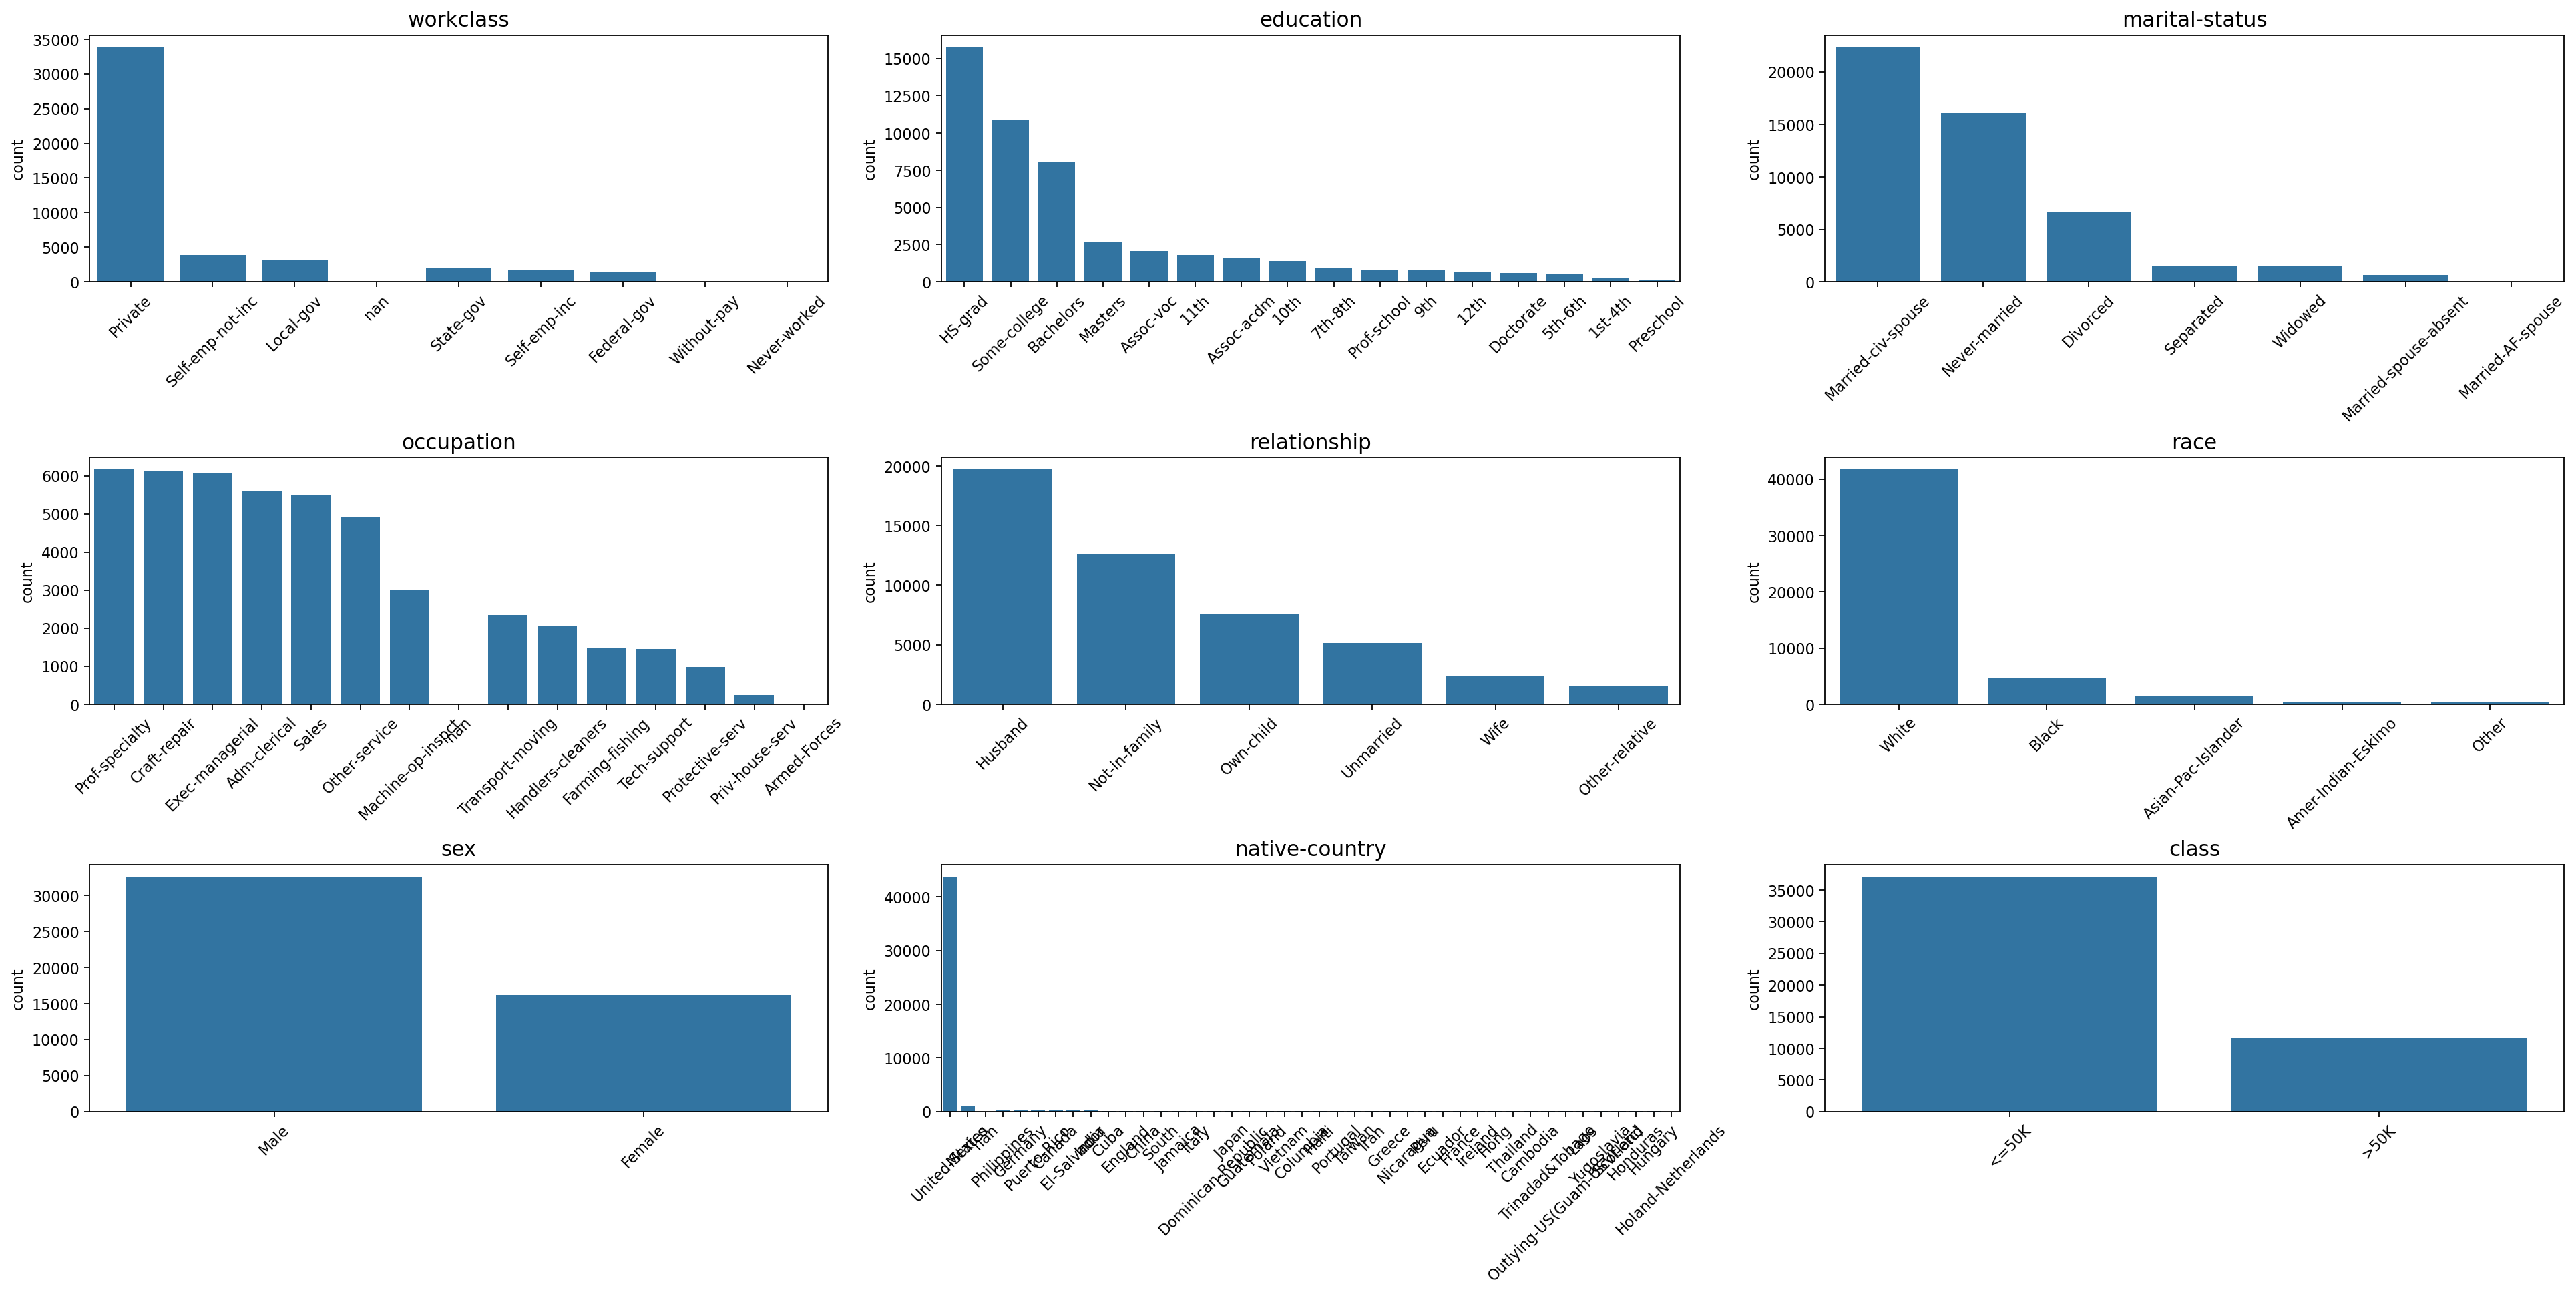

In [95]:

cats = cat_cols[:]          # all categorical cols you want
# If your label is included and you want to exclude it, use: cats = cat_cols[:-1]

n = len(cats)
ncols = 3  # 3 columns per row
nrows = math.ceil(n / ncols) # total rows needed

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(8*ncols, 4*nrows), # width and height of each subplot in inches
    dpi=160, #Dots per inch; higher DPI makes the rendered image sharper and often easier to read in notebooks.
    constrained_layout=True # Adjusts spacing to prevent overlap
)

axes = axes.ravel() 
#axes is usually a 2D arrary (nrows, ncols)
# ravel() flatten it into a 1D array of length nrows*ncols

for i, col in enumerate(cats):
    # Order categories by frequency for readability
    order = df[col].value_counts(dropna=False).index
    sns.countplot(data=df, x=col, order=order, ax=axes[i])
    axes[i].set_title(col, fontsize=14)
    axes[i].tick_params(axis="x", labelrotation=45)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("count")

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.show()

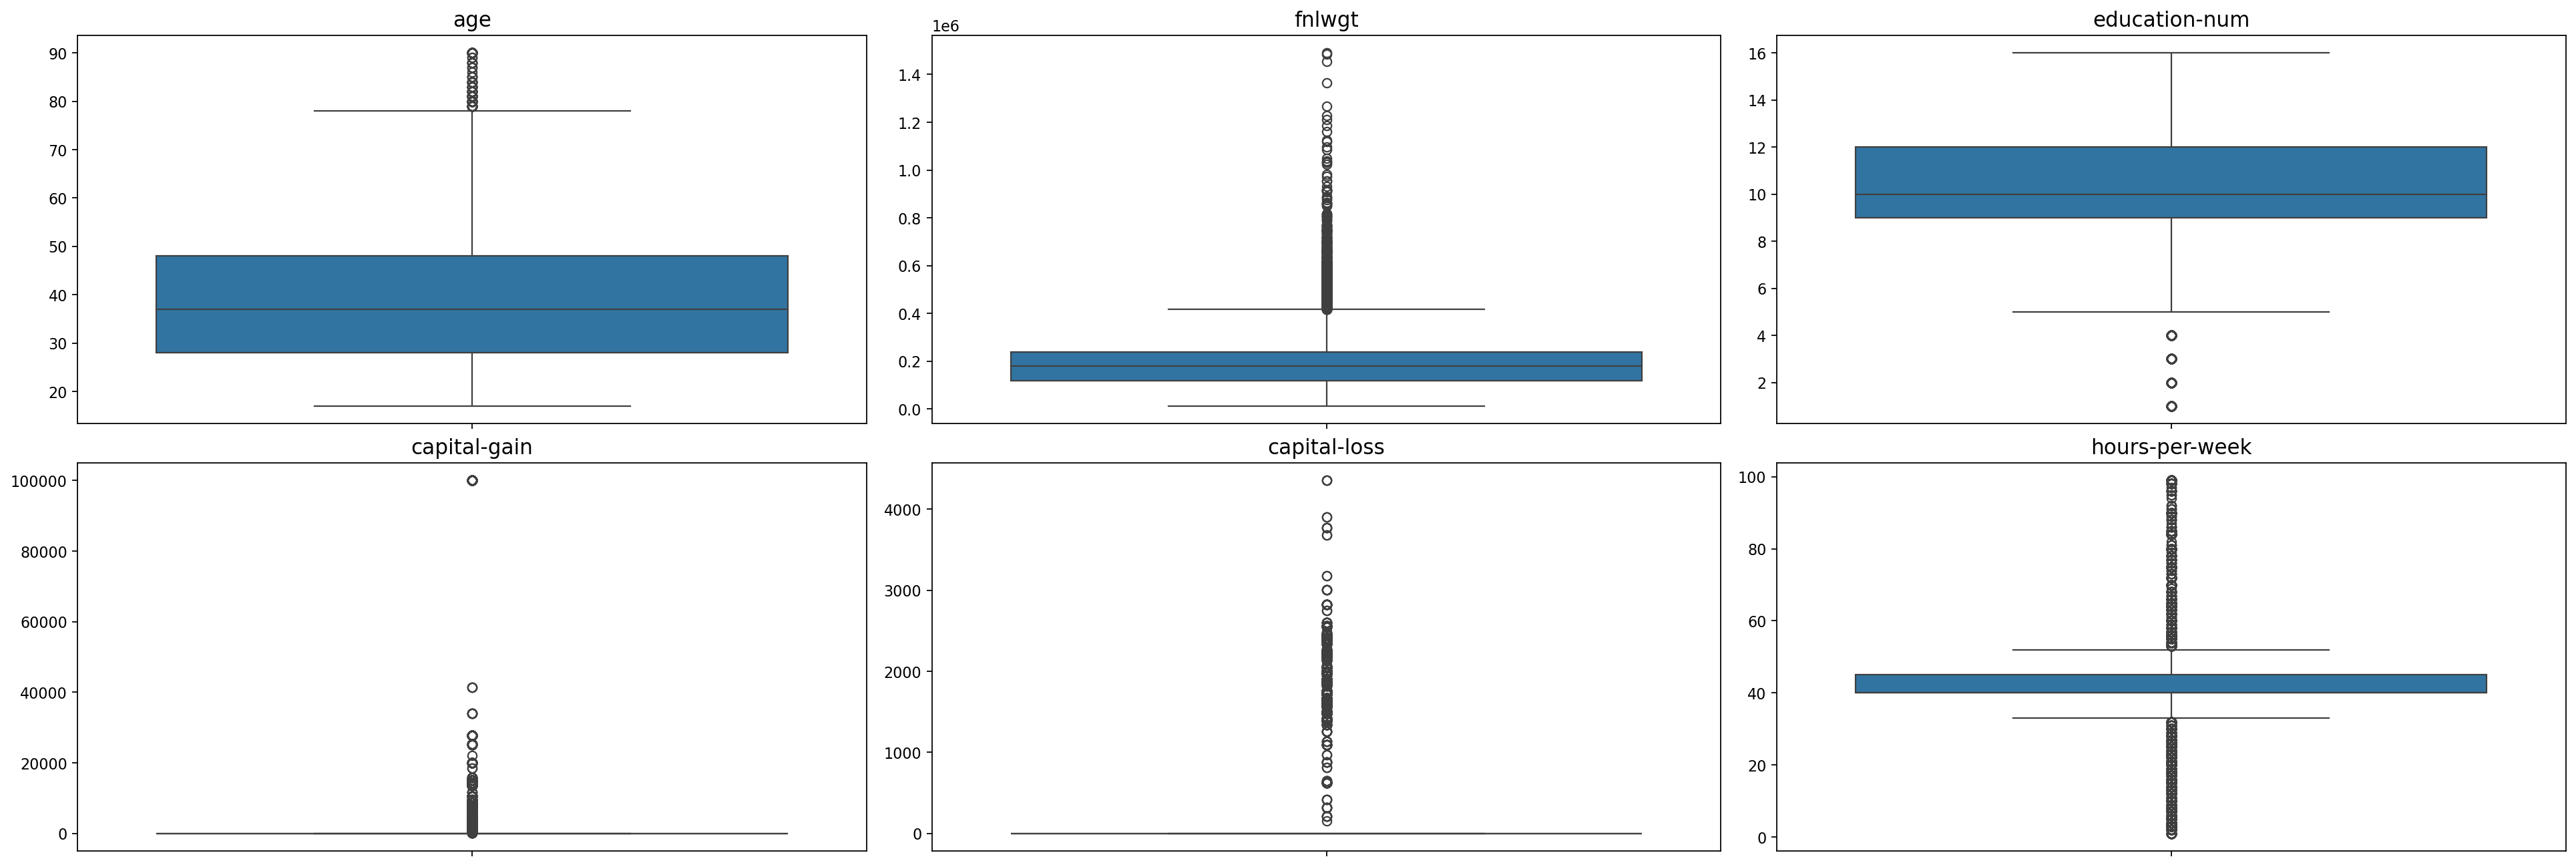

In [96]:
# If you want to exclude the label (example: income encoded as 0/1), do:
# label_col = "income"  # change if needed
# num_cols = [c for c in num_cols if c != label_col]

# 2) Layout
n = len(num_cols)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(8*ncols, 4*nrows),
    dpi=160,
    constrained_layout=True
)

axes = np.array(axes).ravel()

# 3) Boxplots (one per numeric column)
for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(col, fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# 4) Turn off unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.show()

In [97]:
df.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
class                0
dtype: int64

In [98]:
target_col = 'class'  # change if needed
y_raw = df[target_col].astype(str)

y_raw.value_counts()

class
<=50K    37155
>50K     11687
Name: count, dtype: int64

In [99]:
# common labels: <=50k and >50k
y = y_raw.map({'<=50K': 0, '>50K': 1})
X = df.drop(columns=[target_col])

In [100]:
X = df.drop(columns=["fnlwgt"]) #it is a survey sampling weight, not a real feature

In [101]:
# Recompute column lists *after* splitting label/feature
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()

In [102]:
# Safe even if target_col isn't categorical / isn't present
if target_col in cat_cols:
    cat_cols.remove(target_col)


In [103]:
print("Row:", len(df))
print("Positive rate:", y.mean())
print("Categorical cols:", len(cat_cols), ";  Numeric cols:", len(num_cols))

Row: 48842
Positive rate: 0.23928176569346055
Categorical cols: 8 ;  Numeric cols: 5


In [104]:


RANDOM_STATE = 42
#Train: Val: Test = 70:15:15 split
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_tmp
)
print(X_train.shape, X_val.shape, X_test.shape) 

(34189, 14) (7326, 14) (7327, 14)


In [105]:
# Preprocessing: impute + one-hot


# Fill missing numeric with median
numeric_preprocess = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

# Fill missing categorical with most frequent, then one-hot encode
categorical_preprocess = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers = [
        ("num", numeric_preprocess, num_cols),
        ("cat", categorical_preprocess, cat_cols),
    ],
    remainder = "drop", # drop cols not listed in num_cols and cat_cols
    verbose_feature_names_out = False # output clear names
)

# Prefer keeping transformed features as a DataFrame with column names.
# This avoids warnings like: "X does not have valid feature names, but ... was fitted with feature names".
try:
    preprocess.set_output(transform="pandas")
except Exception:
    import warnings
    warnings.filterwarnings(
        "ignore",
        message=r"X does not have valid feature names, but .* was fitted with feature names",
    )

def get_feature_names(preprocessor: ColumnTransformer):
    """Get expanded feature names after ColumnTransformer + OneHot."""
    return preprocessor.get_feature_names_out()



## Day 43 - Train Tree Model 
- XGBoost/LightGBM baseline model
- Evaluate

In [106]:
#!pip install lightgbm
#!pip install xgboost

In [107]:
# Model selection (LightGBM -> SGBoost -> sklearn fallback)
model_name = None

try:
    import lightgbm as lgb
    model = lgb.LGBMClassifier(
        n_estimators=600,
        learning_rate=0.05, 
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE, 
        n_jobs=-1, # use all available CPU cores for training
    )
    model_name = "LightGBM"
except Exception:
    try: 
        from xgboost import XGBClassifier
        model = XGBClassifier(
            n_estimators=600, 
            learning_rate=0.05,
            max_depth=5, 
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0, #L2 regularization on leaf weights, reduce overfitting
            random_state=RANDOM_STATE,
            n_jobs=-1,
            eval_metric="logloss", 
        )
        model_name = "XGBoost"
    except Exception:
        from sklearn.ensemble import HistGradientBoostingClassifier
        model = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
        model_name = "HistGradientBoosting (fallback)"

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

clf.fit(X_train, y_train)
print("Trained:", model_name)


[LightGBM] [Info] Number of positive: 8181, number of negative: 26008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 34189, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239287 -> initscore=-1.156590
[LightGBM] [Info] Start training from score -1.156590
Trained: LightGBM



Validation accuracy=0.8763 roc_auc=0.9272
              precision    recall  f1-score   support

           0     0.9010    0.9408    0.9205      5573
           1     0.7810    0.6714    0.7221      1753

    accuracy                         0.8763      7326
   macro avg     0.8410    0.8061    0.8213      7326
weighted avg     0.8723    0.8763    0.8730      7326



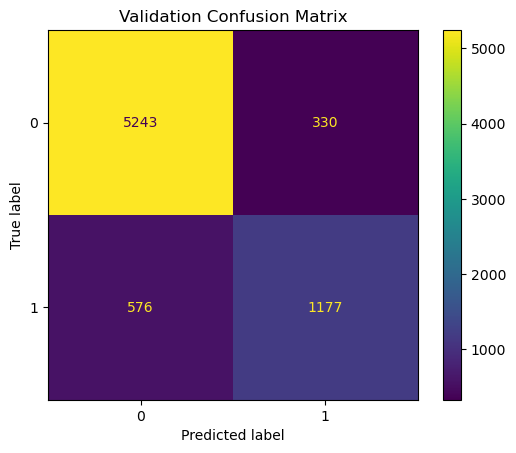


Test accuracy=0.8694 roc_auc=0.9249
              precision    recall  f1-score   support

           0     0.8956    0.9376    0.9161      5574
           1     0.7668    0.6526    0.7051      1753

    accuracy                         0.8694      7327
   macro avg     0.8312    0.7951    0.8106      7327
weighted avg     0.8648    0.8694    0.8656      7327



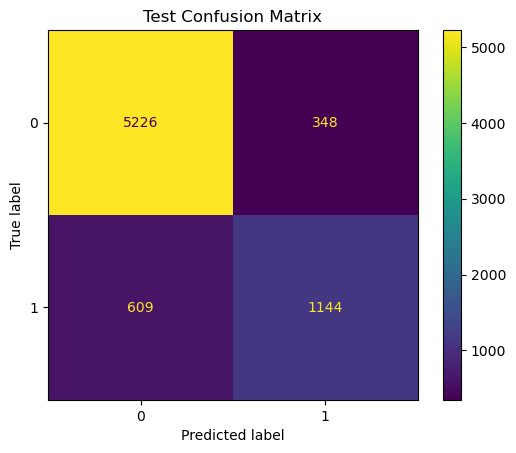

In [108]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

def evaluate(clf, X, y, title=""):
    proba = clf.predict_proba(X)[:,1]
    pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y, pred)
    auc  = roc_auc_score(y, proba)
    print(f"\n{title} accuracy={acc:.4f} roc_auc={auc:.4f}")
    print(classification_report(y, pred, digits=4))
    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(values_format="d")
    plt.title(f"{title} Confusion Matrix")
    plt.show()
    return {"accuracy": acc, "roc_auc": auc}

_ = evaluate(clf, X_val, y_val, title="Validation")
_ = evaluate(clf, X_test, y_test, title="Test")


## Day 44 - Feature Importance
- Global feature importance plots
    - Model-native importance (if available), and
    - Permutation importance (model-agnostic, more reliable)
- Analyze

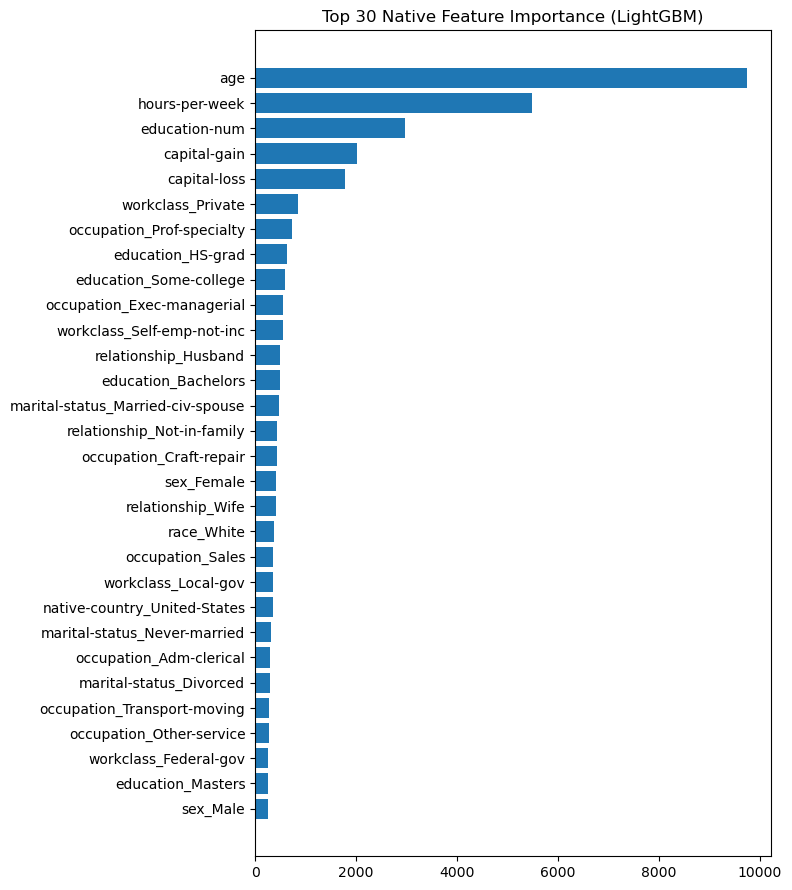

In [109]:
# Fit transform once for importance workflows that need feature names
# Turn raw dataframe into numeric model-ready matrix
pre = clf.named_steps["preprocess"] #clf is the pipeline; named_steps is a dict of pipeline's steps
# Transformed matrices
X_train_t = pre.transform(X_train) # use the already-fitted preprocessor from the pipeline
X_test_t = pre.transform(X_test)
# The names of the transformed columns (after one-hot, etc)
feat_names = get_feature_names(pre)
# The actual trained model inside the pipeline
est = clf.named_steps["model"] #useful when you need model attributes eg. est.feature_imp

# Native importance
native_imp = None
if hasattr(est, "feature_importances_"): # if est has an attribute named feature_importance_, then do...
    native_imp = est.feature_importances_
    imp_df = pd.DataFrame({"feature": feat_names, "importance": native_imp})
    imp_df = imp_df.sort_values("importance", ascending=False).head(30)
    plt.figure(figsize=(8, 9))
    plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1]) #[start:stop:step]
    plt.title(f"Top 30 Native Feature Importance ({model_name})")
    plt.tight_layout()
    plt.show()
else:
    print("No native feature_importance_ on this estimator.")
    

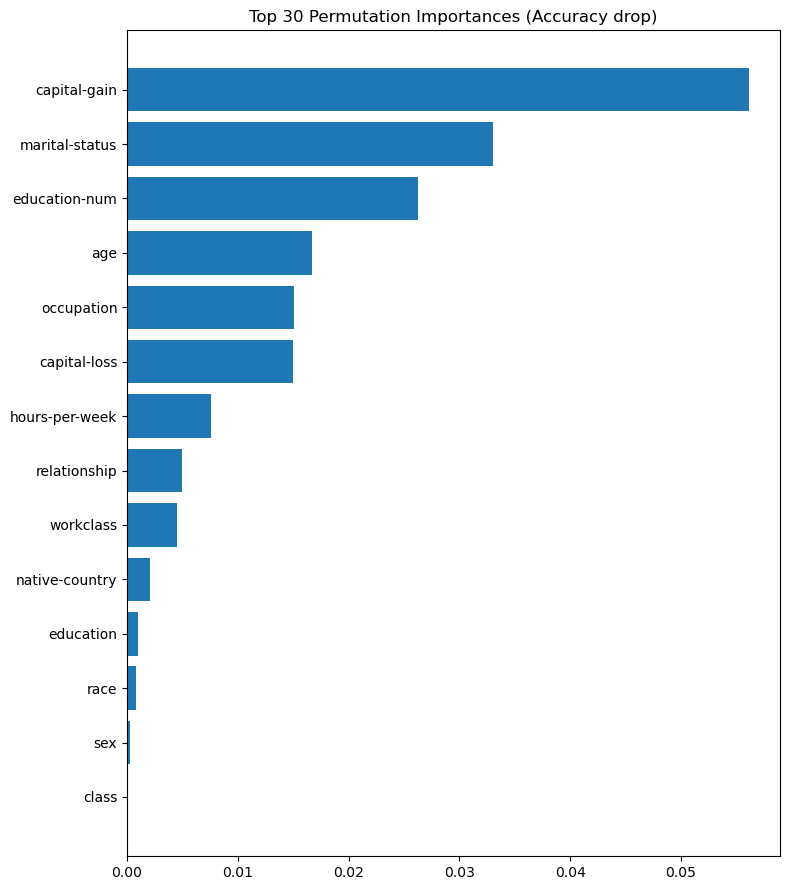

,feature,importance_mean,importance_std
9,capital-gain,0.056135,0.001414
4,marital-status,0.032988,0.002744
3,education-num,0.026259,0.001877
0,age,0.016733,0.001991
5,occupation,0.015081,0.001409
10,capital-loss,0.014945,0.001165
11,hours-per-week,0.007561,0.001522
6,relationship,0.004941,0.001305
1,workclass,0.004531,0.001370
12,native-country,0.002075,0.001156


In [110]:
# Permutation importance on test set (slower but robust)
# For permutation importance, we need a predict function; easiest is on the full pipeline
from sklearn.inspection import permutation_importance
perm = permutation_importance(
    clf, X_test, y_test, 
    n_repeats=10,
    random_state=RANDOM_STATE, 
    scoring="accuracy",
    n_jobs=-1,
)

perm_df = pd.DataFrame({
    # Permuting happens on the *input* columns passed to permutation_importance (i.e., raw X_test columns)
    "feature": list(X_test.columns),
    "importance_mean": perm.importances_mean, 
    "importance_std": perm.importances_std,
}).sort_values("importance_mean", ascending=False).head(30)

plt.figure(figsize=(8, 9))
plt.barh(perm_df["feature"][::-1], perm_df["importance_mean"][::-1])
plt.title("Top 30 Permutation Importances (Accuracy drop)")
plt.tight_layout()
plt.show()

perm_df.head(10)

- importance_mean
    - Bigger: the model relied on that feature more. 
    - Near 0: shuffling didn't hurt accuracy much. 
- importance_std:
    - Smaller: stable estimate
    - Larger: the importance varies more. 

## Day 45 - SHAP
- Compute SHAP values on the transformed feature space (one-hot expanded).
    - It's more reliable workflow for tree boosters + preprocessing.
- Visualize

In [111]:
#%pip install -U shap

/Users/CQ/miniconda3/envs/ml_foundations/lib/python3.11/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


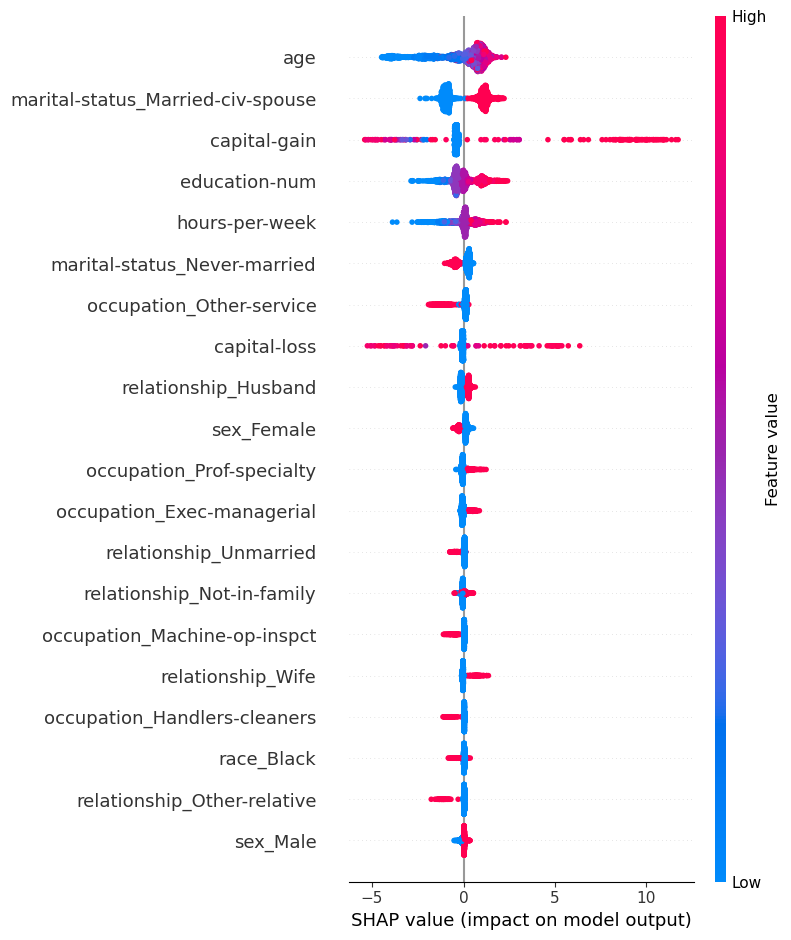

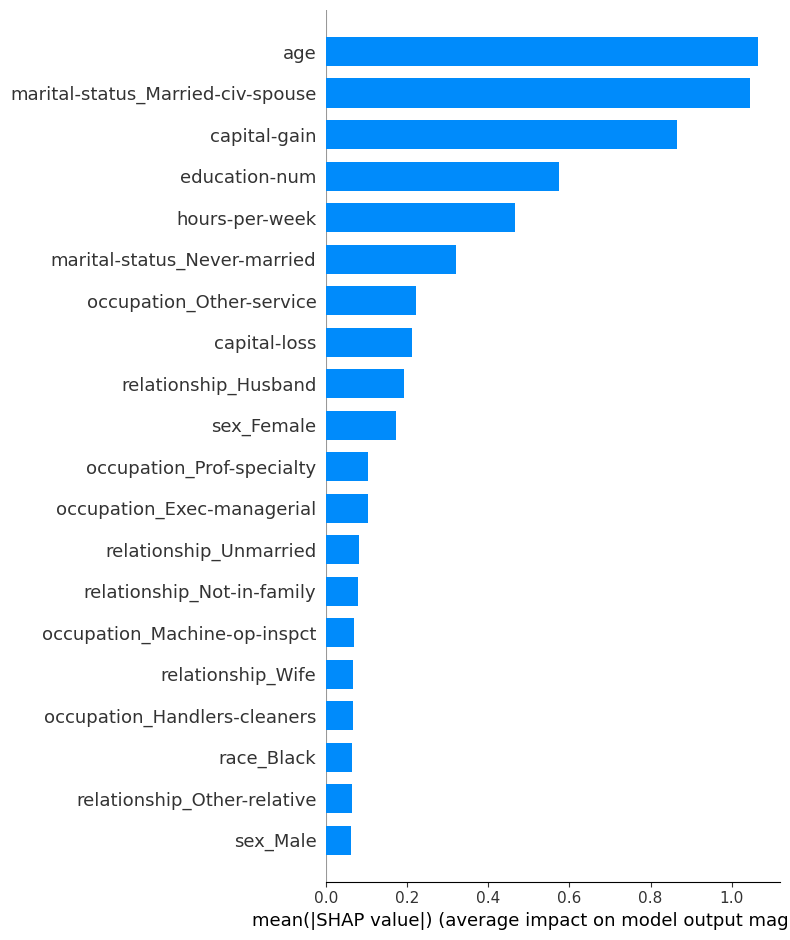

In [112]:
import shap

# Ensure model is trained on transformed features (some estimators are fine either way;
# here we use the already -fit pipeline and transformed matrix)

rng = np.random.default_rng(RANDOM_STATE)
# Get a list of idx
idx = rng.choice(
    X_test_t.shape[0], #row #
    size=min(2000, X_test_t.shape[0]), #min of test items or 2000
    replace=False # no replacement, unique
    )

X_explain = X_test_t.iloc[idx] if isinstance(X_test_t, pd.DataFrame) else X_test_t[idx]
#Convert sparse -> dense for some SHAP plots (map by memory heavy; keep subset small)
if hasattr(X_explain, "toarray"):
    X_explain_dense = X_explain.toarry() #convert sparse-> dense (2D numpy.ndarray (n_samples, n_features))
else:
    X_explain_dense = np.array(X_explain) # already dense (matrix) -> convert to NumPy array

# TreeExplainer works best for LightGBM/XGBoost; for fallback models, shap.Explainer may still work
try: #GBs
    explainer = shap.TreeExplainer(est)
    shap_values = explainer.shap_values(X_explain_dense)
    # For binary classification, shap_values may be a list [class0, class1] or array
    sv = shap_values[1] if isinstance(shap_values, list) else shap_values
        #If shap_values is a list, take the elem at idx 1, otherwise just use shap_values as-is. 
except Exception: #fallback
    explainer = shap.Explainer(est, X_explain_dense) #baseline model need background data as 2nd arg
    sv = explainer(X_explain_dense).values #sv: (n_samples, n_features)

# Summary plot
shap.summary_plot(sv, X_explain_dense, feature_names=feat_names, show=True)

# Bar plot (global)
shap.summary_plot(sv, X_explain_dense, feature_names=feat_names, plot_type="bar", show=True)




This is a **SHAP summary (beeswarm) plot**. It answers two questions at once:

1. **Which features matter most overall?** (top to bottom)
2. **For each feature, do high/low values push the prediction toward >50K or toward <=50K?** (left vs right)

- How to read it

- A) Row order (importance)

Features are sorted by **mean absolute SHAP value** (average impact size).
So `age` is the most influential feature in this plot, then `marital-status_Married-civ-spouse`, then `capital-gain`, etc.

- B) Each dot = one person (one row in your data)

A dot’s **x-position** is that feature’s contribution for that person.

* **SHAP value > 0 (to the right):** pushes the model **toward the positive class** (typically `>50K`, since you plotted SHAP for class 1).
* **SHAP value < 0 (to the left):** pushes the model **away from >50K** (toward `<=50K`).

The vertical line at 0 means “no effect.”

- C) Color = feature value (high vs low)

* **Red = high feature value**
* **Blue = low feature value**

For **one-hot encoded** features (like `marital-status_Married-civ-spouse`):

* **Red usually means 1** (this category is true)
* **Blue usually means 0** (not in this category)

- D) Width/spread = how variable the effect is

* Wider horizontal spread for a feature = its effect changes a lot across people (interactions / nonlinearity).
* A tight cluster near 0 = usually weak or only matters for a subset.

- Read your specific plot (what it’s saying)

* **age:** red dots mostly on the **right** → **older age tends to increase** predicted probability of `>50K`; younger (blue) tends to decrease it.
* **marital-status_Married-civ-spouse:** red on the **right**, blue on the **left** → being married (civilian spouse) is strongly associated with higher predicted income.
* **capital-gain:** high values (red) shoot far to the **right** → when capital-gain is large, it strongly pushes predictions to `>50K`. Low/zero (blue) is near 0 or slightly left.
* **education-num:** higher education-num (red) tends to push **right** → increases predicted income.
* **hours-per-week:** higher hours (red) tends to push **right** → increases predicted income.
* **marital-status_Never-married:** red dots mainly **left** → being never-married tends to decrease predicted income.
* **occupation_Other-service:** red mostly **left** → that occupation category tends to lower predicted income relative to the baseline.
* **relationship_Husband:** red slightly **right** → being “Husband” tends to increase predicted income in the model.
* **sex_Female:** red slightly **left** → female indicator tends to reduce predicted income in the model (association, not causation).
* **occupation_Exec-managerial / Prof-specialty:** red tends to the **right** → those categories increase predicted income.
* **race_Black:** red slightly **left** → in this model/data, that indicator is associated with lower predicted income after other features.

- One critical note

For tree models, SHAP values are often in **model-output units (commonly log-odds for binary classification)**. You can still interpret **direction and relative magnitude** exactly as above. If you want “probability-point” changes, you’d apply the logistic link—helpful but not required to read this plot correctly.



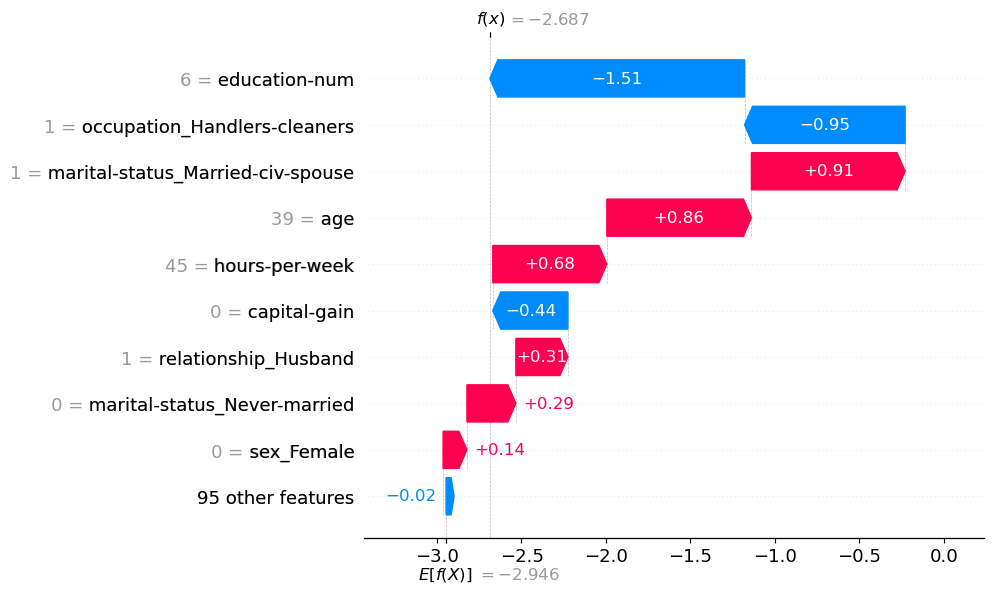

In [113]:
# Optional but useful: pick one person and generate a local explanation
i = 0 # choose an index within X_explain_dense
shap.plots.waterfall(shap.Explanation(values=sv[i], 
                                      base_values=explainer.expected_value if hasattr(explainer, "expected_value") else None, 
                                      data=X_explain_dense[i], feature_names=feat_names))

- Biggest factors pushing down: low education-num, Handlers-cleaners occupation, no capital gain.
- Biggest factors pushing up: married, age, 45 hours/week, husband.
- Net result: still low predicted probability of >50K (final log-odds is strongly negative).


## Day 46 - LIME
- Local explanations
- Compare to SHAP
- Note: LIME needs a predict_proba on the same representation it is explaining. We'll explain in transformed feature space for correctness. 

In [114]:
# %pip install lime

/Users/CQ/miniconda3/envs/ml_foundations/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LIME explanation (class '>50K'):
[('capital-gain <= 0.00', -0.6367260143252957), ('native-country_Holand-Netherlands <= 0.00', -0.2815192680719559), ('native-country_Ecuador <= 0.00', 0.19937445111947358), ('native-country_Thailand <= 0.00', 0.16345040133738048), ('native-country_Haiti <= 0.00', -0.13415471114958238), ('native-country_Honduras <= 0.00', -0.12919875322790778), ('native-country_Canada <= 0.00', -0.12094723408327637), ('native-country_Italy <= 0.00', -0.10272194448939019), ('education_Preschool <= 0.00', -0.08018830867788497), ('workclass_Without-pay <= 0.00', -0.07352881971226057), ('native-country_Yugoslavia <= 0.00', 0.057974392153847656), ('native-country_France <= 0.00', 0.03581191247190553)]


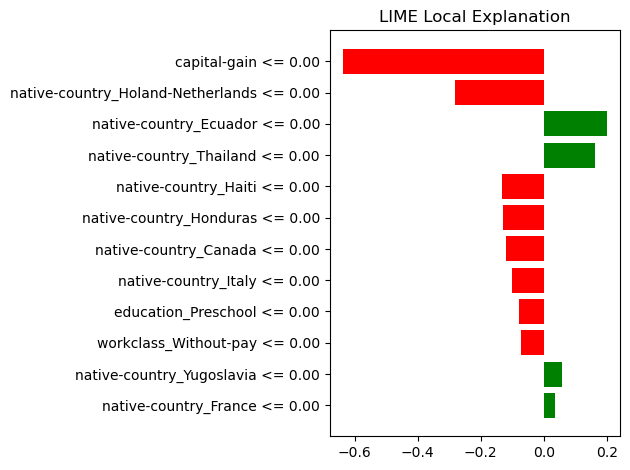

In [115]:
from lime.lime_tabular import LimeTabularExplainer
# Build a lightweight predictor that accepts transformed arrays
def predict_proba_transformed(X_array):
    return est.predict_proba(X_array)

# Prepare training data for LIME (dense sample for practicality)
X_lime_train = X_train_t
if hasattr(X_lime_train, "toarray"):
    # sample to keep it manageable
    sidx = rng.coice(X_lime_train.shape[0], size = min(5000, X_lime_train.shape[0]), replace=False)
    X_lime_train = X_lime_train[sidx].toarray()
else:
    X_lime_train = np.array(X_lime_train)

explainer_lime = LimeTabularExplainer(
    training_data=X_lime_train, 
    feature_names=feat_names, 
    class_names=["<=50K", ">50K"], 
    discretize_continuous=True, #group data in bins
    mode="classification", 
    random_state=RANDOM_STATE,
)

# Explain a single test instance
j = 0
x0 = X_explain_dense[j]
exp = explainer_lime.explain_instance(
    data_row=x0, 
    predict_fn=predict_proba_transformed, 
    num_features=12,
)
print("LIME explanation (class '>50K'):")
print(exp.as_list())

fig = exp.as_pyplot_figure()
plt.title("LIME Local Explanation")
plt.tight_layout()
plt.show()


- Bar lenth = strength of local effect
- var <= 0.00 - means 0 in one-hot - the category is not present for this person. 
- red - toward negative, green-toward positive

For this person, LIME suggests:
- Main reason for low >50K probability: capital-gain = 0 (strong negative effect).
- Other contributions are dominated by sparse one-hot categories (native-country, some education/workclass indicators), which are less reliable as explanations.



## Day 47 - Bootstrapping
    - If you had drawn a different test set from the same population, how much might my accuracy change?
- Bootstraps the test set to get a Confidence intervals for accuracy
- Interpret

Bootstrap 95% CI for test accuracy: [0.8616, 0.8773]


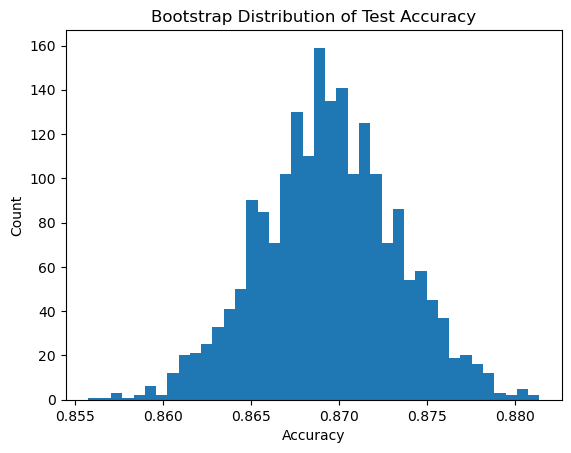

In [116]:
def bootstrap_ci_accuracy(clf, X_test, y_test, iter=2000, alpha=0.05, seed=RANDOM_STATE): # B: # of iteration; alpha: confidence level eg.5%; 95% confidence
    rng = np.random.default_rng(seed)
    n = len(y_test)
    y_test_arr = np.array(y_test)

    accs = np.empty(iter, dtype=float)
    for i in range(iter):
        idx = rng.integers(low=0, high=n, size=n) # resample indices with replacement; n is size of resampling
        Xb = X_test.iloc[idx] if isinstance(X_test, pd.DataFrame) else X_test[idx]
        yb = y_test_arr[idx]
        pred = clf.predict(Xb)
        accs[i] = accuracy_score(yb, pred)

    lo = np.quantile(accs, alpha/2)
    hi = np.quantile(accs, 1-alpha/2)
    return accs, lo, hi

accs, lo, hi = bootstrap_ci_accuracy(clf, X_test, y_test, iter=2000)
print(f"Bootstrap 95% CI for test accuracy: [{lo:.4f}, {hi:.4f}]")

plt.hist(accs, bins=40)
plt.title("Bootstrap Distribution of Test Accuracy")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.show()



## Day 48 - Document Insights
- Plots Summary
- README template


# Adult Income — Tree Model + Explainability

### Goal
Predict whether annual income is `>50K` using the UCI Adult dataset, and produce global + local explanations.

### Data
- Source: OpenML “adult” (UCI Adult)
- Rows: 48842
- Positive class rate (>50K): 11687/48842 = 23.93%

### Model
- Baseline: LightGBM/XGBoost/HistGradientBoostingClassifier
- Preprocessing: 
    - median imputation (numeric) - SimpleImputer(strategy="median")
        - Median is robust to outliers/skew (Adult has skewed variables like capit-gain)
    - most-frequent (categorical) = SimpleImputer(strategy="most_frequent")
        - Replaces missing categories with the mode.
    - one-hot encoding - OneHotEncoder(handle_unknown="ignore", sparse_output=True)
        - handle_unknown = "ignore" prevents errors when test/production has unseen categories 
            because it ignores test or validate unseen categories which are not trained yet
        - sparse_out = True keeps the one-hot matrix sparse (memory-efficient)
    - Pipeline: ColumnTransformer(num, cat)-> model (fit preprocessing on train, transform val/test)

### Metrics (Test)
- Accuracy: 0.8690
- ROC-AUC: 0.9240
- Confusion Matrix: (include screenshot)
    ![alt text](image.png)

### Global Explanations
Overall, across the whole datsest, what does the model rely on?

- Native importance top drivers: 1.capital-gain, 2.age, 3.education-num, 4.hours-per-week,      5.workclass_private, followed by occupation, relationship
- Permutation importance top drivers: 1.capital-gain, 2.marital_status_*, 3.education-num
4.age, 5.occupation, followed by occupation, capital_loss
- Key takeaway: (2–4 bullets)
    - Both methods agree that income is driven primarily by a mix of financial signals (capital-gain) and human-capital/time signals (education-num, age, hours-per-week), plus family/role features (marital-status, relationship).
    - Native importance can overweight features used frequently in splits (and can be spread across many one-hot columns), while permutation importance is more directly tied to predictive dependence (impact on metrics).
    - capital-gain is usually dominant but also highly skewed with many zeros, so it can create strong decision rules for a small subset of records; interpret its importance with that context.
    - One-hot categorical drivers often appear as groups (e.g., multiple marital-status_* categories); for reporting, it’s often cleaner to aggregate importances by original feature family.


### Local Explanations
- For this specific person, why did the model predict > 50k or not?

SHAP: example A — top pushes toward >50K: 
- marital-status_Married-civ-spouse = 1 (positive push, ~+0.91)
- age = 39 (positive push, ~+0.86)
- hours-per-week = 45 (positive push, ~+0.68)
- relationship_Husband = 1 (positive push, ~+0.31)
- (smaller) sex_Female = 0 / “not female” (positive push, ~+0.14)

LIME: example A — top pushes toward >50K: 
- native-country_Ecuador <= 0.00 (green; “not Ecuador”)
- native-country_Thailand <= 0.00 (green; “not Thailand”)
- native-country_Yugoslavia <= 0.00 (green; “not Yugoslavia”)
- native-country_France <= 0.00 (green; “not France”)

Comparison note: where SHAP vs LIME agree/disagree and why.
- Agreement: Both methods identify capital-gain = 0 as a major negative driver for >50K in this instance (SHAP shows a negative contribution; LIME shows it as the largest red bar).
- Disagreement: SHAP highlights core, semantically meaningful drivers for this case (marital status, age, hours/week, relationship), while LIME’s top positive drivers are dominated by one-hot “native-country_ <= 0” indicators* (“not country X”).
- Why they differ:
    - SHAP (TreeExplainer) attributes contributions based on the trained tree model structure and tends to be more stable for tree models.
    - LIME fits a local linear surrogate using perturbed samples; with high-dimensional sparse one-hot features, it often selects arbitrary/unstable indicators (e.g., many “not country” columns) that help the surrogate locally but are less interpretable and may not be robust.
- Usage: For this tabular + tree setup, use SHAP as the primary local explanation, and treat LIME as a secondary check—especially wary when LIME is driven by many sparse one-hot negatives.


### Uncertainty (Bootstrapping)
- 95% CI for test accuracy: [0.8616, 0.8773]
Interpretation: The interval width is only 1.57%, so the model's test accuracy estimate is reasonably precise. 

- Next steps (practical):
    - Quantify group performance and disparity on the test set: accuracy, precision/recall, FPR/FNR by sex and race; also check selection rate and metrics like demographic parity difference and equal opportunity difference.
    - Assess proxy features (e.g., marital-status, occupation, relationship) that can correlate with protected classes; evaluate whether they drive disparate impact even if you drop sex/race.
    - Run “with vs without” experiments: retrain models excluding sex and race and compare both overall utility and group disparities; if performance drop is small, prefer the constrained model.
    - If the use case is high-stakes, consider fairness-aware mitigation (reweighing, constrained optimization, post-processing thresholds by group where legally/ethically appropriate) and implement monitoring for drift and disparity over time.
    - Document limitations clearly: this dataset is observational; explanations are associative, not causal, and fairness conclusions depend on intended use.
